## Notes 

- want to be around the participant's net value = 0 point to see subtle shifts in cost-benefit integration reflected in behaviour

- since net value depends on participant's k, pre-test this

- same stimuli (except positive vs negative value) for approach and avoid blocks

- for confidence decisions think about sorting by variances and boundary to affect average confidence


### Import stuff

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
import random
from sklearn.utils import shuffle

### Pre-test k value
<span style="color:red">could add an early stopping rule if k converges quickly?</span>

In [2]:
example_ks = np.linspace(0.1, 0.9, 5)

#### Most basic with fixed step size and random reward-effort combinations



 ______ True-k = 0.10 ______ Estimated-k = 0.10 ______ Difference = 0.00  



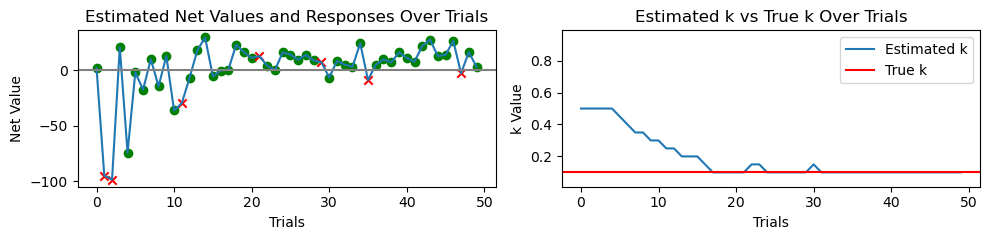



 ______ True-k = 0.30 ______ Estimated-k = 0.40 ______ Difference = 0.10  



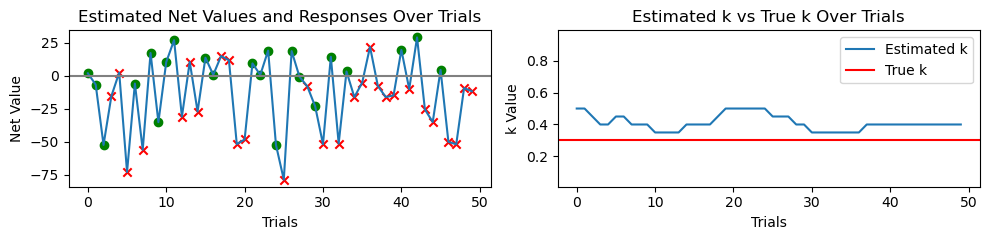



 ______ True-k = 0.50 ______ Estimated-k = 0.65 ______ Difference = 0.15  



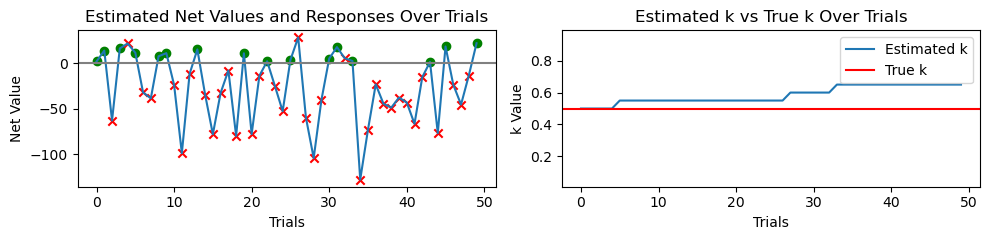



 ______ True-k = 0.70 ______ Estimated-k = 0.50 ______ Difference = 0.20  



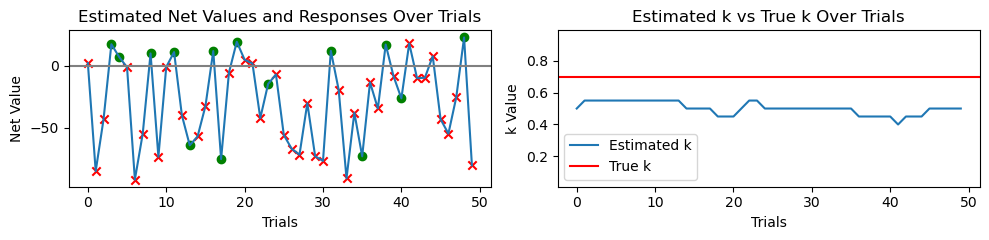



 ______ True-k = 0.90 ______ Estimated-k = 0.90 ______ Difference = 0.00  



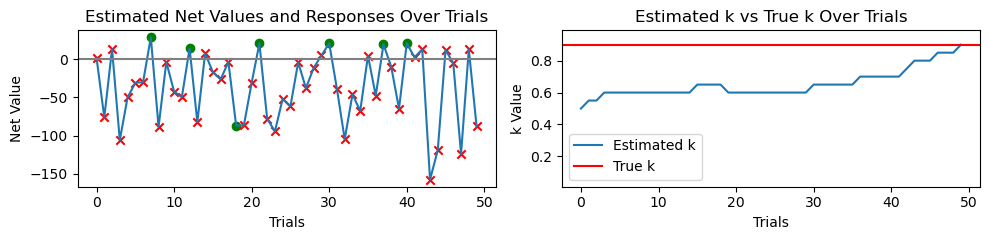

In [3]:
def calculate_net_value(reward, effort, k):
    return reward - k * effort ** 2


def simulate_response(reward, effort, true_k, noise=0.1):
    net_value = calculate_net_value(reward, effort, true_k)
    response = 'accept' if net_value > 0 else 'reject'
    # flip the response with a probability equal to noise
    if np.random.rand() < noise:
        response = 'reject' if response == 'accept' else 'accept'
    return response



def estimate_k(simulate_response, true_k, initial_k=0.5, max_trials=50):
    
    estimated_k = initial_k
    
    # initial values for reward and effort - net value = 2 assuming a k of 0.5
    reward, effort = 20, 6  
    
    # record values for visualization
    rewards, efforts, estimated_ks, estimated_net_values, responses = [], [], [], [], []

    for trial in range(max_trials):
        # would insert true response here
        response = simulate_response(reward, effort, true_k)

        # estimated net value based on current estimated k
        estimated_net_value = calculate_net_value(reward, effort, estimated_k)

        # record values for visualization
        rewards.append(reward)
        efforts.append(effort)
        estimated_ks.append(estimated_k)
        estimated_net_values.append(estimated_net_value)
        responses.append(response)

        # update k based on response with fixed step size
        if estimated_net_value < 0 and response == 'accept':
            estimated_k = estimated_k - 0.05
        elif estimated_net_value > 0 and response == 'reject':
            estimated_k = estimated_k + 0.05

        # adjust reward and/or effort for the next trial randomly
        # reward between 10 and 30, effort between 1 and 10
        reward = np.random.uniform(10, 30)
        effort = np.random.uniform(1, 15)
        
    return estimated_k, rewards, efforts, estimated_ks, estimated_net_values, responses


# simulate with different k values
for true_k in example_ks:

    estimated_k, rewards, efforts, estimated_ks, estimated_net_values, responses = estimate_k(simulate_response, true_k)
    
    print('\033[1m' + "\n\n ______ True-k = %.2f ______ Estimated-k = %.2f ______ Difference = %.2f  \n" % (true_k, estimated_k, abs(true_k-estimated_k)) + '\033[0m')


    plt.figure(figsize=(10, 2.5))

    # plot for estimated net values and responses over trials
    plt.subplot(1, 2, 1)
    plt.plot(estimated_net_values, label='Estimated Net Values')
    plt.axhline(y=0, color='grey', linestyle='-')
    plt.scatter(range(len(responses)), [estimated_net_values[i] if res == 'accept' else None for i, res in enumerate(responses)], color='green', marker='o', label='Accept')
    plt.scatter(range(len(responses)), [estimated_net_values[i] if res == 'reject' else None for i, res in enumerate(responses)], color='red', marker='x', label='Reject')
    plt.xlabel('Trials')
    plt.ylabel('Net Value')
    plt.title('Estimated Net Values and Responses Over Trials')
    # plt.legend()
    
    
    # plot for estimated k vs true k over trials
    plt.subplot(1, 2, 2)
    plt.plot(estimated_ks, label='Estimated k')
    plt.axhline(y=true_k, color='r', linestyle='-', label='True k')
    ax = plt.gca()
    ax.set_ylim([0.01, 0.99])
    plt.xlabel('Trials')
    plt.ylabel('k Value')
    plt.title('Estimated k vs True k Over Trials')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [4]:
# check performance over multiple simulations
# 1000 true_k values between 0.001 and 0.999
true_ks = np.linspace(0.001, 0.999, 1000)


differences = []

for true_k in true_ks:
    estimated_k, _, _, _, _, _ = estimate_k(simulate_response, true_k)
    difference = abs(true_k - estimated_k)
    differences.append(difference)

print('average difference ' + str(round(np.mean(differences), 3)))
print('sd difference ' + str(round(np.std(differences), 3)))


average difference 0.122
sd difference 0.115


#### Adding adaptive step size log decay



 ______ True-k = 0.10 ______ Estimated-k = 0.28 ______ Difference = 0.18  



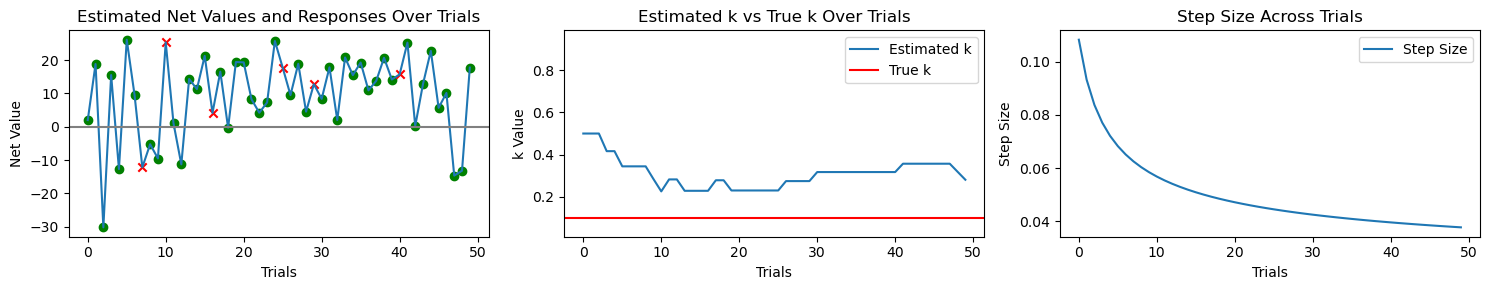



 ______ True-k = 0.30 ______ Estimated-k = 0.39 ______ Difference = 0.09  



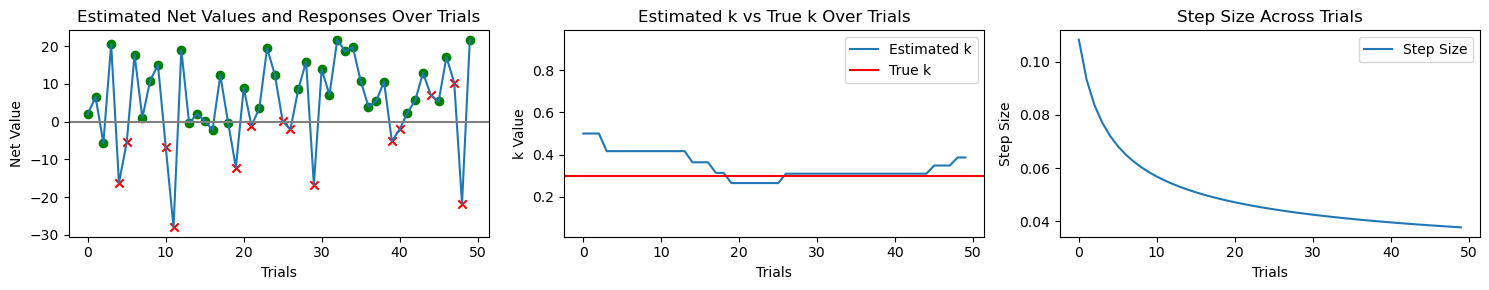



 ______ True-k = 0.50 ______ Estimated-k = 0.55 ______ Difference = 0.05  



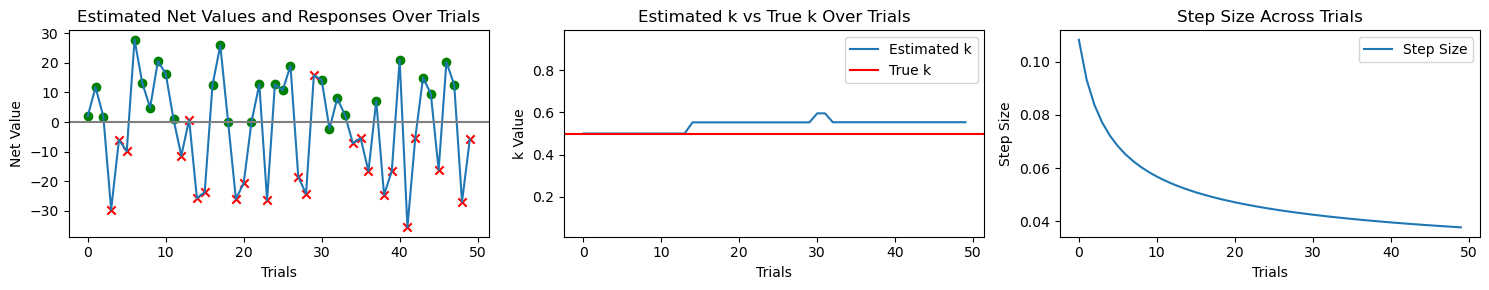



 ______ True-k = 0.70 ______ Estimated-k = 0.69 ______ Difference = 0.01  



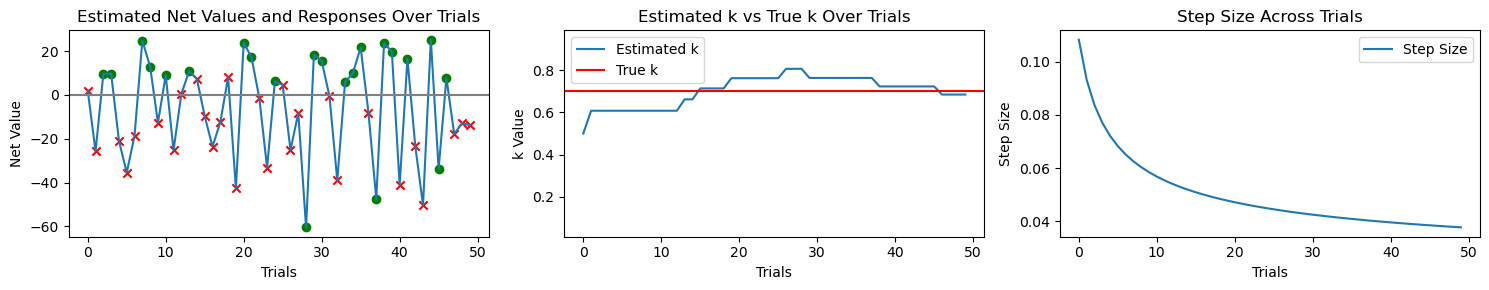



 ______ True-k = 0.90 ______ Estimated-k = 0.73 ______ Difference = 0.17  



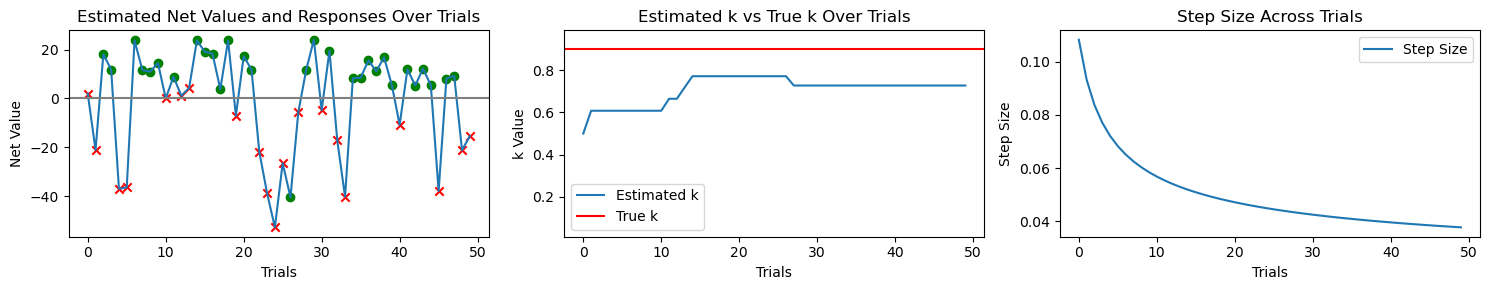

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_net_value(reward, effort, k):
    return reward - k * effort ** 2

def simulate_response(reward, effort, true_k, noise=0.1):
    net_value = calculate_net_value(reward, effort, true_k)
    response = 'accept' if net_value > 0 else 'reject'
    if np.random.rand() < noise:
        response = 'reject' if response == 'accept' else 'accept'
    return response

def estimate_k(simulate_response, true_k, initial_k=0.5, max_trials=50):
    estimated_k = initial_k
    reward, effort = 20, 6
    rewards, efforts, estimated_ks, estimated_net_values, responses, step_sizes = [], [], [], [], [], []

    for trial in range(max_trials):
        response = simulate_response(reward, effort, true_k)
        estimated_net_value = calculate_net_value(reward, effort, estimated_k)

        rewards.append(reward)
        efforts.append(effort)
        estimated_ks.append(estimated_k)
        estimated_net_values.append(estimated_net_value)
        responses.append(response)

        step_size = 0.15 / np.log(trial + 4)
        step_sizes.append(step_size)

        if estimated_net_value < 0 and response == 'accept':
            estimated_k -= step_size
        elif estimated_net_value > 0 and response == 'reject':
            estimated_k += step_size

        reward = np.random.uniform(10, 30)
        effort = np.random.uniform(1, 10)
        
    return estimated_k, rewards, efforts, estimated_ks, estimated_net_values, responses, step_sizes

# simulate with different k values
for true_k in example_ks:
    estimated_k, rewards, efforts, estimated_ks, estimated_net_values, responses, step_sizes = estimate_k(simulate_response, true_k)
    
    print('\033[1m' + "\n\n ______ True-k = %.2f ______ Estimated-k = %.2f ______ Difference = %.2f  \n" % (true_k, estimated_k, abs(true_k-estimated_k)) + '\033[0m')

    plt.figure(figsize=(15, 3))

    # plot for estimated net values and responses over trials
    plt.subplot(1, 3, 1)
    plt.plot(estimated_net_values, label='Estimated Net Values')
    plt.axhline(y=0, color='grey', linestyle='-')
    plt.scatter(range(len(responses)), [estimated_net_values[i] if res == 'accept' else None for i, res in enumerate(responses)], color='green', marker='o', label='Accept')
    plt.scatter(range(len(responses)), [estimated_net_values[i] if res == 'reject' else None for i, res in enumerate(responses)], color='red', marker='x', label='Reject')
    plt.xlabel('Trials')
    plt.ylabel('Net Value')
    plt.title('Estimated Net Values and Responses Over Trials')
    
    # plot for estimated k vs true k over trials
    plt.subplot(1, 3, 2)
    plt.plot(estimated_ks, label='Estimated k')
    plt.axhline(y=true_k, color='r', linestyle='-', label='True k')
    ax = plt.gca()
    ax.set_ylim([0.01, 0.99])
    plt.xlabel('Trials')
    plt.ylabel('k Value')
    plt.title('Estimated k vs True k Over Trials')
    plt.legend()

    # plot for step size across trials
    plt.subplot(1, 3, 3)
    plt.plot(step_sizes, label='Step Size')
    plt.xlabel('Trials')
    plt.ylabel('Step Size')
    plt.title('Step Size Across Trials')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [6]:
# check performance over multiple simulations
# 1000 true_k values between 0.001 and 0.999
true_ks = np.linspace(0.001, 0.999, 1000)


differences = []

for true_k in true_ks:
    estimated_k, _, _, _, _, _, _ = estimate_k(simulate_response, true_k)
    difference = abs(true_k - estimated_k)
    differences.append(difference)

print('average difference ' + str(round(np.mean(differences), 3)))
print('sd difference ' + str(round(np.std(differences), 3)))


average difference 0.097
sd difference 0.076


#### Choose informative reward-effort combinations



 ______ True-k = 0.10 ______ Estimated-k = 0.20 ______ Difference = 0.10  



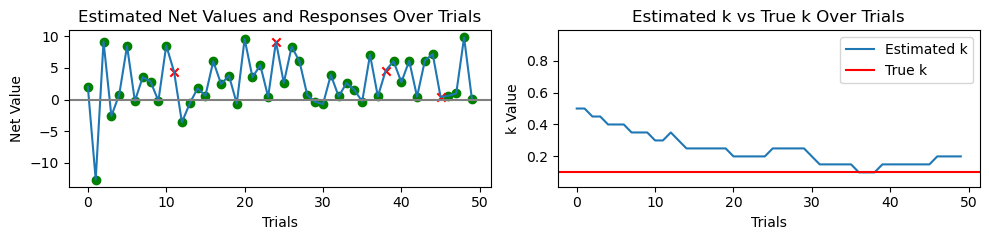



 ______ True-k = 0.30 ______ Estimated-k = 0.30 ______ Difference = 0.00  



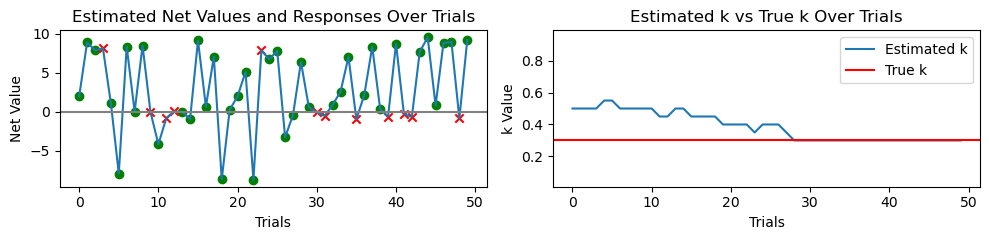



 ______ True-k = 0.50 ______ Estimated-k = 0.50 ______ Difference = 0.00  



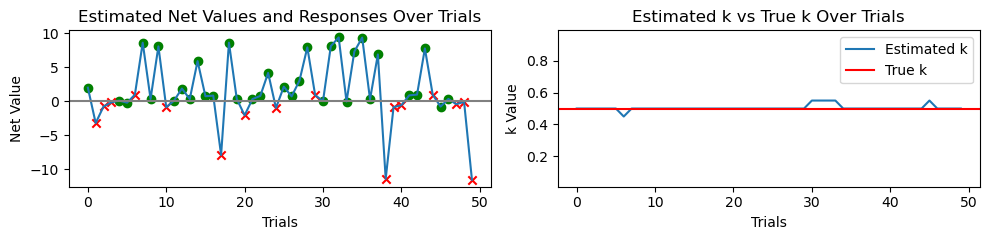



 ______ True-k = 0.70 ______ Estimated-k = 0.75 ______ Difference = 0.05  



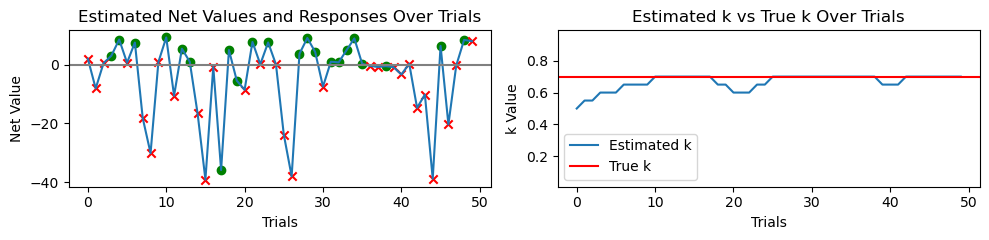



 ______ True-k = 0.90 ______ Estimated-k = 0.75 ______ Difference = 0.15  



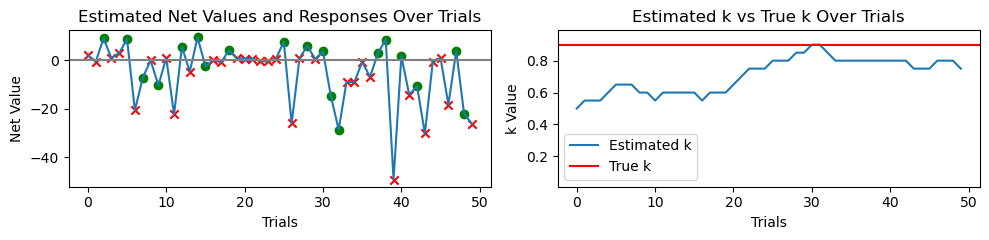

In [7]:
def calculate_net_value(reward, effort, k):
    return reward - k * effort ** 2


def simulate_response(reward, effort, true_k, noise=0.1):
    net_value = calculate_net_value(reward, effort, true_k)
    response = 'accept' if net_value > 0 else 'reject'
    # flip the response with a probability equal to noise
    if np.random.rand() < noise:
        response = 'reject' if response == 'accept' else 'accept'
    return response



def estimate_k(simulate_response, true_k, initial_k=0.5, max_trials=50):
    
    estimated_k = initial_k
    
    # initial values for reward and effort - net value = 2 assuming a k of 0.5
    reward, effort = 20, 6  
    
    # record values for visualization
    rewards, efforts, estimated_ks, estimated_net_values, responses = [], [], [], [], []

    for trial in range(max_trials):
        # would insert true response here
        response = simulate_response(reward, effort, true_k)

        # estimated net value based on current estimated k
        estimated_net_value = calculate_net_value(reward, effort, estimated_k)

        # record values for visualization
        rewards.append(reward)
        efforts.append(effort)
        estimated_ks.append(estimated_k)
        estimated_net_values.append(estimated_net_value)
        responses.append(response)

        # update k based on response with fixed step size
        if estimated_net_value < 0 and response == 'accept':
            estimated_k = estimated_k - 0.05
        elif estimated_net_value > 0 and response == 'reject':
            estimated_k = estimated_k + 0.05

        # adjust reward and effort for next trial to aim for a net value close to zero
        # reward between 10 and 30, effort between 1 and 10
        target_net_value = np.random.uniform(-1, 1) 
        next_effort = np.random.uniform(1, 10)   # consider making not random (list with all possible, sample without replacement)
        next_reward = estimated_k * next_effort ** 2 + target_net_value
        reward, effort = max(min(next_reward, 30), 10), next_effort
        
    return estimated_k, rewards, efforts, estimated_ks, estimated_net_values, responses


# simulate with different k values
for true_k in example_ks:

    estimated_k, rewards, efforts, estimated_ks, estimated_net_values, responses = estimate_k(simulate_response, true_k)
    
    print('\033[1m' + "\n\n ______ True-k = %.2f ______ Estimated-k = %.2f ______ Difference = %.2f  \n" % (true_k, estimated_k, abs(true_k-estimated_k)) + '\033[0m')


    plt.figure(figsize=(10, 2.5))

    # plot for estimated net values and responses over trials
    plt.subplot(1, 2, 1)
    plt.plot(estimated_net_values, label='Estimated Net Values')
    plt.axhline(y=0, color='grey', linestyle='-')
    plt.scatter(range(len(responses)), [estimated_net_values[i] if res == 'accept' else None for i, res in enumerate(responses)], color='green', marker='o', label='Accept')
    plt.scatter(range(len(responses)), [estimated_net_values[i] if res == 'reject' else None for i, res in enumerate(responses)], color='red', marker='x', label='Reject')
    plt.xlabel('Trials')
    plt.ylabel('Net Value')
    plt.title('Estimated Net Values and Responses Over Trials')
    # plt.legend()
    
    
    # plot for estimated k vs true k over trials
    plt.subplot(1, 2, 2)
    plt.plot(estimated_ks, label='Estimated k')
    plt.axhline(y=true_k, color='r', linestyle='-', label='True k')
    ax = plt.gca()
    ax.set_ylim([0.01, 0.99])
    plt.xlabel('Trials')
    plt.ylabel('k Value')
    plt.title('Estimated k vs True k Over Trials')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [8]:
# check performance over multiple simulations
# 1000 true_k values between 0.001 and 0.999
true_ks = np.linspace(0.001, 0.999, 1000)


differences = []

for true_k in true_ks:
    estimated_k, _, _, _, _, _ = estimate_k(simulate_response, true_k)
    difference = abs(true_k - estimated_k)
    differences.append(difference)

print('average difference ' + str(round(np.mean(differences), 3)))
print('sd difference ' + str(round(np.std(differences), 3)))


average difference 0.054
sd difference 0.056


#### Both adaptive step size and informative offers



 ______ True-k = 0.10 ______ Estimated-k = 0.27 ______ Difference = 0.17  



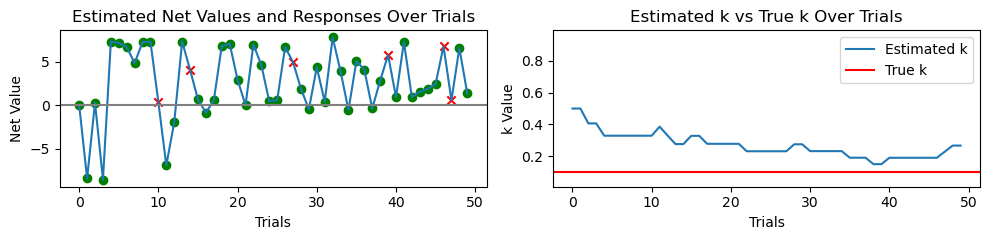



 ______ True-k = 0.30 ______ Estimated-k = 0.31 ______ Difference = 0.01  



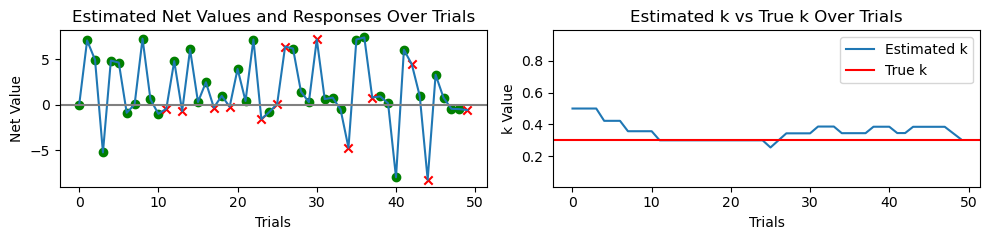



 ______ True-k = 0.50 ______ Estimated-k = 0.50 ______ Difference = 0.00  



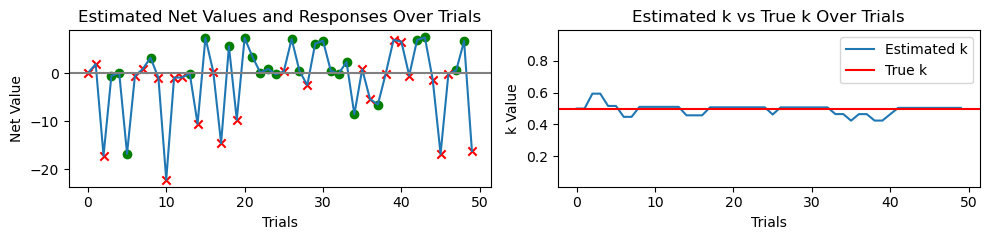



 ______ True-k = 0.70 ______ Estimated-k = 0.70 ______ Difference = 0.00  



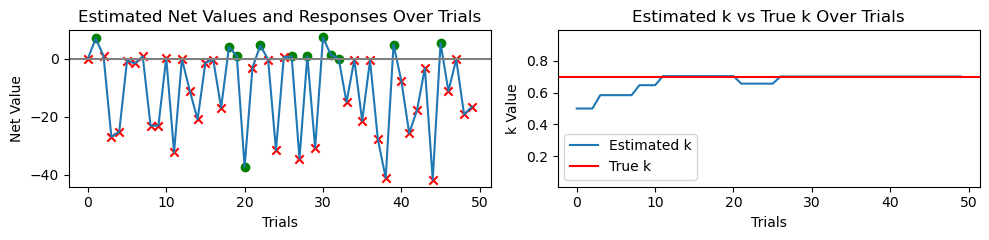



 ______ True-k = 0.90 ______ Estimated-k = 0.90 ______ Difference = 0.00  



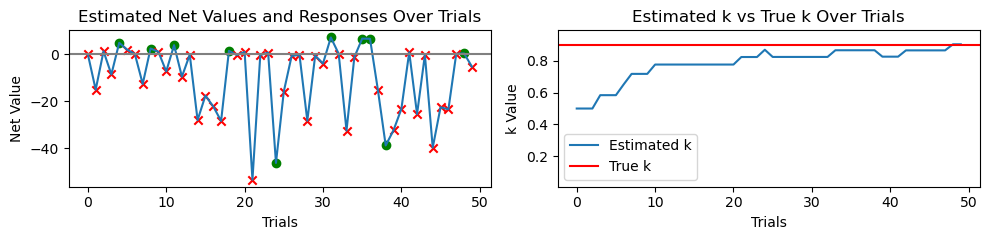

In [9]:
def calculate_net_value(reward, effort, k):
    return reward - k * effort ** 2


def simulate_response(reward, effort, true_k, noise=0.1):   #make noise softmax - noise increases as we move away from net value = 0
    net_value = calculate_net_value(reward, effort, true_k)
    response = 'accept' if net_value > 0 else 'reject'
    # flip the response with a probability equal to noise
    if np.random.rand() < noise:
        response = 'reject' if response == 'accept' else 'accept'
    return response



def estimate_k(simulate_response, true_k, initial_k=0.5, max_trials=50):
    
    estimated_k = initial_k
    
    # initial values for reward and effort - net value = 2 assuming a k of 0.5
    reward, effort = 18, 6  
    
    # record values for visualization
    rewards, efforts, estimated_ks, estimated_net_values, responses = [], [], [], [], []

    for trial in range(max_trials):
        # would insert true response here
        response = simulate_response(reward, effort, true_k)

        # estimated net value based on current estimated k
        estimated_net_value = calculate_net_value(reward, effort, estimated_k)

        # record values for visualization
        rewards.append(reward)
        efforts.append(effort)
        estimated_ks.append(estimated_k)
        estimated_net_values.append(estimated_net_value)
        responses.append(response)

        # update k based on response 
        # adaptive step size using logarithmic decay
        step_size = 0.15 / np.log(trial + 4)
        if estimated_net_value < 0 and response == 'accept':
            estimated_k = estimated_k - step_size
        elif estimated_net_value > 0 and response == 'reject':
            estimated_k = estimated_k + step_size

        # adjust reward and effort for next trial to aim for a net value close to zero
        # reward between 10 and 30, effort between 1 and 10
        target_net_value = np.random.uniform(-1, 1) 
        next_effort = np.random.uniform(1, 10)
        next_reward = estimated_k * next_effort ** 2 + target_net_value
        reward, effort = max(min(next_reward, 28), 8), next_effort
        
    return estimated_k, rewards, efforts, estimated_ks, estimated_net_values, responses


# simulate with different k values
for true_k in example_ks:

    estimated_k, rewards, efforts, estimated_ks, estimated_net_values, responses = estimate_k(simulate_response, true_k)
    
    print('\033[1m' + "\n\n ______ True-k = %.2f ______ Estimated-k = %.2f ______ Difference = %.2f  \n" % (true_k, estimated_k, abs(true_k-estimated_k)) + '\033[0m')


    plt.figure(figsize=(10, 2.5))

    # plot for estimated net values and responses over trials
    plt.subplot(1, 2, 1)
    plt.plot(estimated_net_values, label='Estimated Net Values')
    plt.axhline(y=0, color='grey', linestyle='-')
    plt.scatter(range(len(responses)), [estimated_net_values[i] if res == 'accept' else None for i, res in enumerate(responses)], color='green', marker='o', label='Accept')
    plt.scatter(range(len(responses)), [estimated_net_values[i] if res == 'reject' else None for i, res in enumerate(responses)], color='red', marker='x', label='Reject')
    plt.xlabel('Trials')
    plt.ylabel('Net Value')
    plt.title('Estimated Net Values and Responses Over Trials')
    # plt.legend()
    
    
    # plot for estimated k vs true k over trials
    plt.subplot(1, 2, 2)
    plt.plot(estimated_ks, label='Estimated k')
    plt.axhline(y=true_k, color='r', linestyle='-', label='True k')
    ax = plt.gca()
    ax.set_ylim([0.01, 0.99])
    plt.xlabel('Trials')
    plt.ylabel('k Value')
    plt.title('Estimated k vs True k Over Trials')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [10]:
# check performance over multiple simulations
# 1000 true_k values between 0.001 and 0.999
true_ks = np.linspace(0.001, 0.999, 1000)


differences = []

for true_k in true_ks:
    estimated_k, _, _, _, _, _ = estimate_k(simulate_response, true_k)
    difference = abs(true_k - estimated_k)
    differences.append(difference)

print('average difference ' + str(round(np.mean(differences), 3)))
print('sd difference ' + str(round(np.std(differences), 3)))


average difference 0.046
sd difference 0.051


<span style="color:red">could add an early stopping rule if k converges quickly?</span>
<span style="color:red">could try also make reward informative rather than just effort?</span>
only make them actually do the effort in e.g. a third of trials

### Define stimuli, net-values, and effort calculation

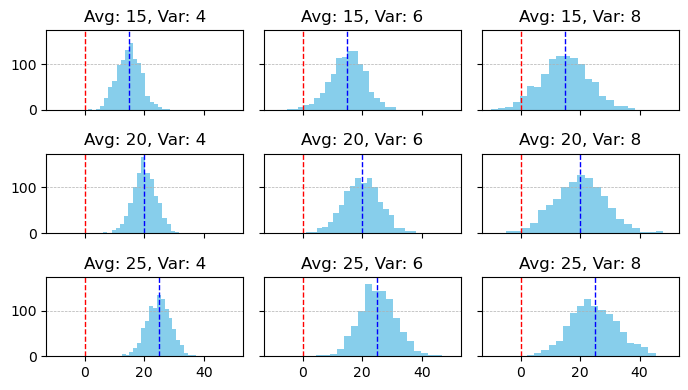

In [11]:
# define 9 stimuli # consider adding one with average value = 0 ? 
reward_means = [15, 20, 25]  # three different means
reward_variances = [4, 6, 8]  # three different variances

stimuli = [(mean, variance) for mean in reward_means for variance in reward_variances]

# visualise reward distributions of the 9 types
def simulate_rewards(avg, var, num_samples=1000):
    return np.random.normal(avg, var, num_samples)

fig, axes = plt.subplots(3, 3, figsize=(7, 4), sharex=True, sharey=True)
for i, (avg, var) in enumerate(stimuli):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    rewards = simulate_rewards(avg, var)
    ax.hist(rewards, bins=20, color='skyblue')
    ax.axvline(avg, color='blue', linestyle='dashed', linewidth=1)
    ax.axvline(0, color='red', linestyle='dashed', linewidth=1)
    ax.set_title(f'Avg: {avg}, Var: {var}')
    ax.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [12]:
# define 5 net values
net_values = [-5, -2.5, 0, 2.5, 5]

In [13]:
# define effort
def calculate_effort(net_value, reward, k):
    """
    Calculates the effort based on the net value, reward, and k.
    The equation used is net_value = reward - k * effort ** 2.

    Parameters:
    net_value (float): The net value of the reward-effort combination.
    reward (float): The reward value.
    k (float): The participant-specific constant.

    Returns:
    float: The calculated effort.
    """
    # Rearranging the equation: net_value = reward - k * effort ** 2 to solve for effort
    # effort ** 2 = (reward - net_value) / k
    # effort = sqrt((reward - net_value) / k)

    effort_square = (reward - net_value) / k
    return effort_square ** 0.5


### Generate stimuli
<span style="color:red">For pre-testing k, effort ranged from 1 to 10. However, here for k=0.1, effort would have to go as high as 17... do the absolute numbers make sense?? </span>

present each stimulus-net value combination - i.e. here 9x5 trials (maybe too many if we do both approach and avoid blocks + then also confidence trials)



----------------------- k = 0.100000 -----------------------




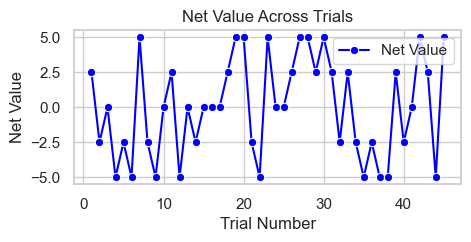

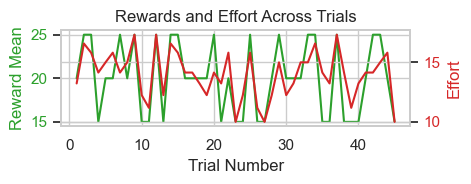



----------------------- k = 0.300000 -----------------------




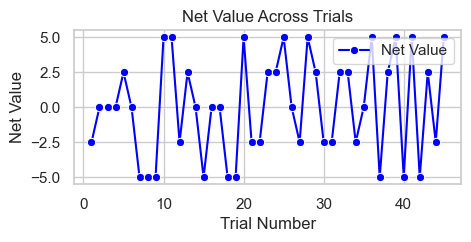

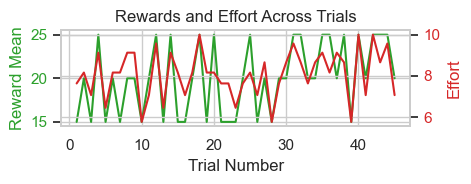



----------------------- k = 0.500000 -----------------------




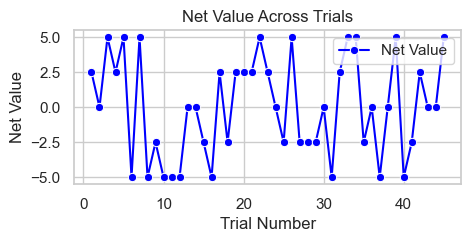

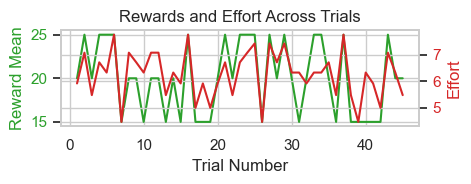



----------------------- k = 0.700000 -----------------------




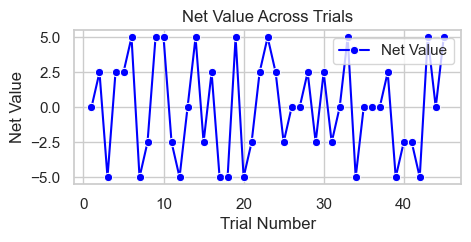

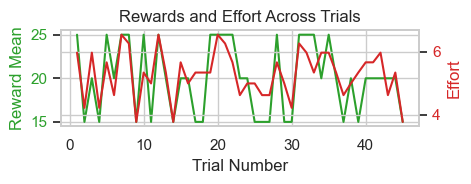



----------------------- k = 0.900000 -----------------------




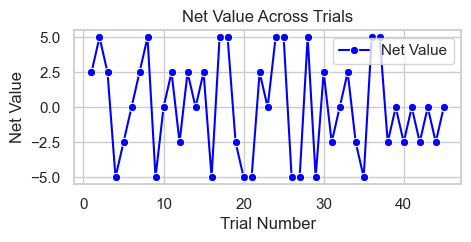

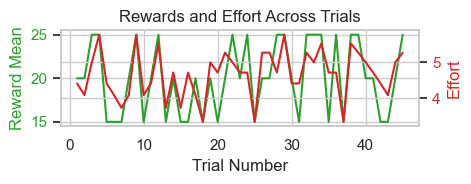

In [14]:
for k in example_ks: 
    print('\033[1m' + "\n\n----------------------- k = %f -----------------------\n" % k)
    print('\033[0m')

    # create dataframe with stimuli
    data = []

    for mean, variance in stimuli:
        for net_value in net_values:
            # calculate effort for each stimulus-net_value combination
            try:
                effort = calculate_effort(net_value, mean, k)
                data.append({
                    'reward_mean': mean,
                    'reward_variance': variance,
                    'net_value': net_value,
                    'k': k,
                    'effort': effort
                })
            except ValueError:
                # In case the square root of a negative number is encountered
                continue

    df_stimuli = pd.DataFrame(data)

    # shuffle the dataframe
    shuffled_df = shuffle(df_stimuli).reset_index(drop=True)

    # a a column for trial number
    shuffled_df['trial_number'] = shuffled_df.index + 1
    #shuffled_df.head(10) 




    # Plotting
    # Net Value across trials
    sns.set(style="whitegrid")
    plt.figure(figsize=(5, 2))
    sns.lineplot(data=shuffled_df, x='trial_number', y='net_value', marker='o', color='blue', label='Net Value')
    plt.title('Net Value Across Trials')
    plt.xlabel('Trial Number')
    plt.ylabel('Net Value')
    plt.show()


    # Reward vs Effort across trials
    fig, ax1 = plt.subplots(figsize=(5, 2))
    # Plotting Reward Mean
    color = 'tab:green'
    ax1.set_xlabel('Trial Number')
    ax1.set_ylabel('Reward Mean', color=color)
    ax1.plot(shuffled_df['trial_number'], shuffled_df['reward_mean'], color=color, label='Reward Mean')
    ax1.tick_params(axis='y', labelcolor=color)
    # Creating a second y-axis for Effort
    ax2 = ax1.twinx()  
    color = 'tab:red'
    ax2.set_ylabel('Effort', color=color)
    ax2.plot(shuffled_df['trial_number'], shuffled_df['effort'], color=color, label='Effort')
    ax2.tick_params(axis='y', labelcolor=color)
    # Adding a title and showing the plot
    plt.title('Rewards and Effort Across Trials')
    fig.tight_layout()
    plt.show()

In [15]:
# plot cors between offered efforts and rewards and net values 
# set reward values bit lower!
# pair every stimulus with 3 choice boundaries
# think about trial times, block times, etc

### Plot how k affects net value - effort relationship

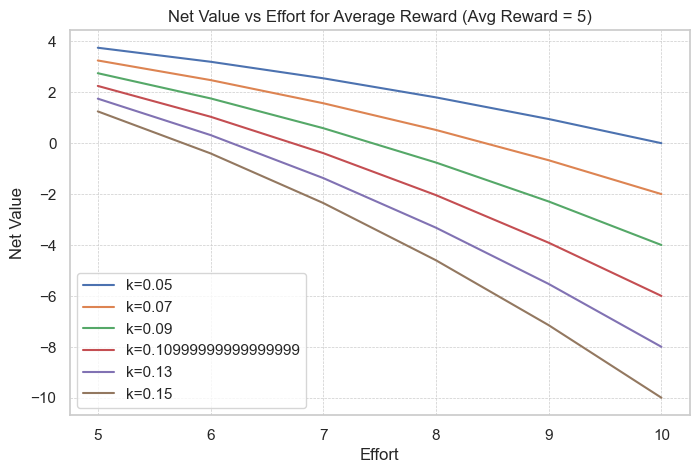

In [18]:
# plot net value versus effort for different k values
plt.figure(figsize=(8, 5))

k_values = np.linspace(0.05, 0.15, 6) 
effort_levels = np.linspace(5, 10, 6)

for k in k_values:
    net_values = []
    for effort in effort_levels:
        # sample an average reward (taking the middle mean for demonstration)
        reward = 5
        net_value = reward - k * effort ** 2
        net_values.append(net_value)
    plt.plot(effort_levels, net_values, label=f'k={k}')


plt.title('Net Value vs Effort for Average Reward (Avg Reward = 5)')
plt.xlabel('Effort')
plt.ylabel('Net Value')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()
